In [1]:
import plaidml.keras
plaidml.keras.install_backend()

import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
cwd = os.getcwd()

from keras import backend as K

In [2]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from keras.models import Sequential
from keras.layers import Cropping2D

In [3]:
import glob
import cv2 as cv

path = glob.glob("C:\\Users\\alikr\\Projects\\JupyterNotebook\\Deep Learning\\Çalışmalar\\maskedAndUnmasked\\veriler\\*\\*")

In [4]:
FAST_RUN = False

In [5]:
imgnames = []
for i in range(len(path)):
    imgnames.append(path[i].split("\\")[-1])
imgnames

['00000_Mask.jpg',
 '00000_Mask_Mouth_Chin.jpg',
 '00001_Mask.jpg',
 '00001_Mask_Chin.jpg',
 '00001_Mask_Mouth_Chin.jpg',
 '00002_Mask.jpg',
 '00002_Mask_Mouth_Chin.jpg',
 '00003_Mask.jpg',
 '00003_Mask_Mouth_Chin.jpg',
 '00004_Mask.jpg',
 '00004_Mask_Mouth_Chin.jpg',
 '00005_Mask.jpg',
 '00005_Mask_Mouth_Chin.jpg',
 '00006_Mask.jpg',
 '00007_Mask.jpg',
 '00007_Mask_Mouth_Chin.jpg',
 '00008_Mask.jpg',
 '00008_Mask_Mouth_Chin.jpg',
 '00009_Mask.jpg',
 '00010_Mask.jpg',
 '00010_Mask_Mouth_Chin.jpg',
 '00011_Mask.jpg',
 '00011_Mask_Mouth_Chin.jpg',
 '00012_Mask.jpg',
 '00012_Mask_Chin.jpg',
 '00013_Mask.jpg',
 '00013_Mask_Mouth_Chin.jpg',
 '00014_Mask.jpg',
 '00014_Mask_Mouth_Chin.jpg',
 '00015_Mask.jpg',
 '00015_Mask_Mouth_Chin.jpg',
 '00016_Mask.jpg',
 '00016_Mask_Mouth_Chin.jpg',
 '00017_Mask.jpg',
 '00017_Mask_Chin.jpg',
 '00018_Mask.jpg',
 '00018_Mask_Mouth_Chin.jpg',
 '00019_Mask.jpg',
 '00019_Mask_Chin.jpg',
 '00020_Mask.jpg',
 '00020_Mask_Mouth_Chin.jpg',
 '00021_Mask.jpg',
 '0002

In [6]:
categories = []
for imgname in imgnames:
    category = len(imgname.split('_'))
    if category == 2:
        categories.append(str(1))
    else:
        categories.append(str(0))
df = pd.DataFrame({
'filename': path,
'category': categories
})

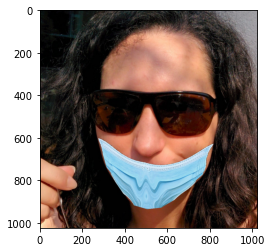

In [7]:
sample = random.choice(path)
image = load_img(sample)
plt.imshow(image)

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size= (3,3)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation = 'softmax')) 

model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

model.summary()

INFO:plaidml:Opening device "opencl_amd_gfx1012.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 42, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 42, 42, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 40, 40, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
__________

In [9]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [10]:
earlystop = EarlyStopping(patience = 2)

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor = "val_acc",
                                           patience = 2,
                                           verbose = 1,
                                           factor = 0.5,
                                           min_lr = 0.001)

In [12]:
callbacks = [earlystop, learning_rate_reduction]

In [13]:
df_ = df

In [14]:
train_df, validate_df = train_test_split(df_, test_size = 0.05, random_state = 42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop = True)

<AxesSubplot:>

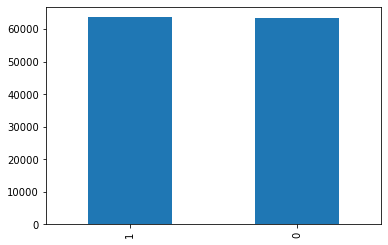

In [15]:
train_df["category"].value_counts().plot.bar()

<AxesSubplot:>

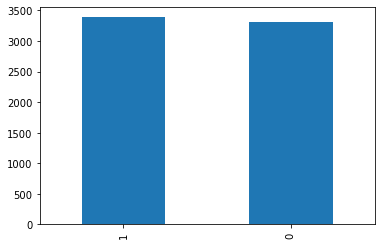

In [16]:
validate_df["category"].value_counts().plot.bar()

In [17]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 25

In [18]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True
)

In [19]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col = 'filename',
    y_col = 'category',
    class_mode = "categorical",
    target_size = (128, 128),
    batch_size = batch_size
)

Found 127092 validated image filenames belonging to 2 classes.


In [20]:
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    x_col = "filename",
    y_col = "category",
    target_size = (128,128),
    class_mode = "categorical",
    batch_size = batch_size
)

Found 6690 validated image filenames belonging to 2 classes.


In [21]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    x_col = "filename",
    y_col = "category",
    target_size = (128, 128),
    class_mode = "categorical"
)

Found 1 validated image filenames belonging to 1 classes.


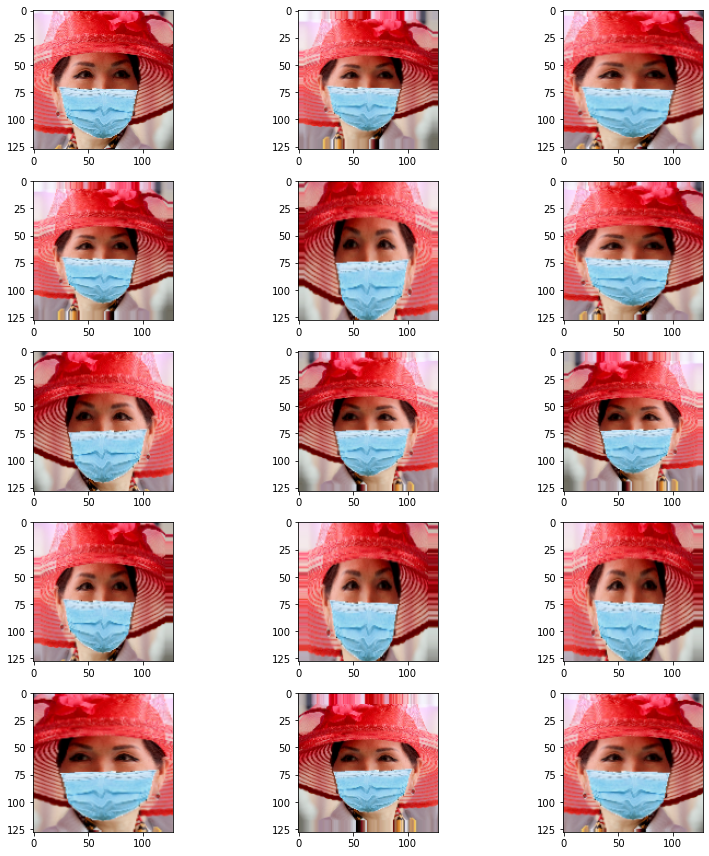

In [22]:
plt.figure(figsize = (12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [23]:
epochs = 3 if FAST_RUN else 10
history = model.fit_generator(
    train_generator,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = total_validate//batch_size,
    steps_per_epoch = total_train//batch_size,
    callbacks = callbacks
)

Epoch 1/10
8472/8472 [==============================] - 3878s 458ms/step - loss: 0.5154 - acc: 0.7496 - val_loss: 0.9853 - val_acc: 0.5284
Epoch 2/10
8472/8472 [==============================] - 2793s 330ms/step - loss: 0.2585 - acc: 0.8986 - val_loss: 0.1973 - val_acc: 0.9232
Epoch 3/10
8472/8472 [==============================] - 2792s 330ms/step - loss: 0.2455 - acc: 0.9109 - val_loss: 0.2492 - val_acc: 0.9052
Epoch 4/10
8472/8472 [==============================] - 2975s 351ms/step - loss: 0.2163 - acc: 0.9235 - val_loss: 0.1700 - val_acc: 0.9425
Epoch 5/10
8472/8472 [==============================] - 3004s 355ms/step - loss: 0.2493 - acc: 0.9038 - val_loss: 0.3534 - val_acc: 0.8900
Epoch 6/10
8472/8472 [==============================] - 2736s 323ms/step - loss: 0.1986 - acc: 0.9290 - val_loss: 0.1839 - val_acc: 0.9396

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.001.


In [24]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers = 12)
print("Test: accuracy = %f ; loss = %f" % (accuracy, loss))

Test: accuracy = 0.939611 ; loss = 0.183943


<ipython-input-25-4ff572e718a8>:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1, len(model_history.history[acc])+1), len(model_history.history[acc])/10)
<ipython-input-25-4ff572e718a8>:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1, len(model_history.history["loss"])+1), len(model_history.history["loss"])/10)


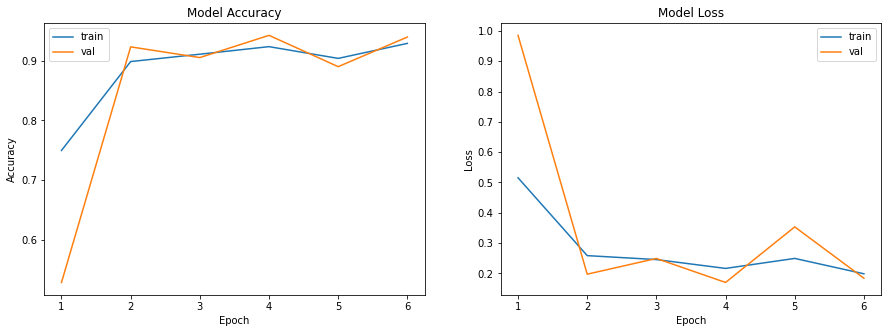

In [25]:
def plot_model_history(model_history, acc ='acc', val_acc = 'val_acc'):
    fig, axs = plt.subplots(1, 2, figsize= (15,5))
    axs[0].plot(range(1, len(model_history.history[acc])+1), model_history.history[acc])
    axs[0].plot(range(1, len(model_history.history[val_acc])+1), model_history.history[val_acc])
    axs[0].set_title("Model Accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].set_xlabel("Epoch")
    axs[0].set_xticks(np.arange(1, len(model_history.history[acc])+1), len(model_history.history[acc])/10)
    axs[0].legend(["train", "val"], loc = "best")
    axs[1].plot(range(1, len(model_history.history["loss"])+1), model_history.history["loss"])
    axs[1].plot(range(1, len(model_history.history["val_loss"])+1), model_history.history["val_loss"])
    axs[1].set_title("Model Loss")
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_xticks(np.arange(1, len(model_history.history["loss"])+1), len(model_history.history["loss"])/10)
    axs[1].legend(["train", "val"], loc = "best")
    plt.show()

plot_model_history(history)

In [26]:
Y_val = validate_df["category"]
y_pred = model.predict_generator(validation_generator)

In [27]:
threshold = 0.5
y_final = np.where(y_pred > threshold, 1, 0)

In [28]:
y_final.size

13380

In [48]:
y_final[3:10]

array([[0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0]])

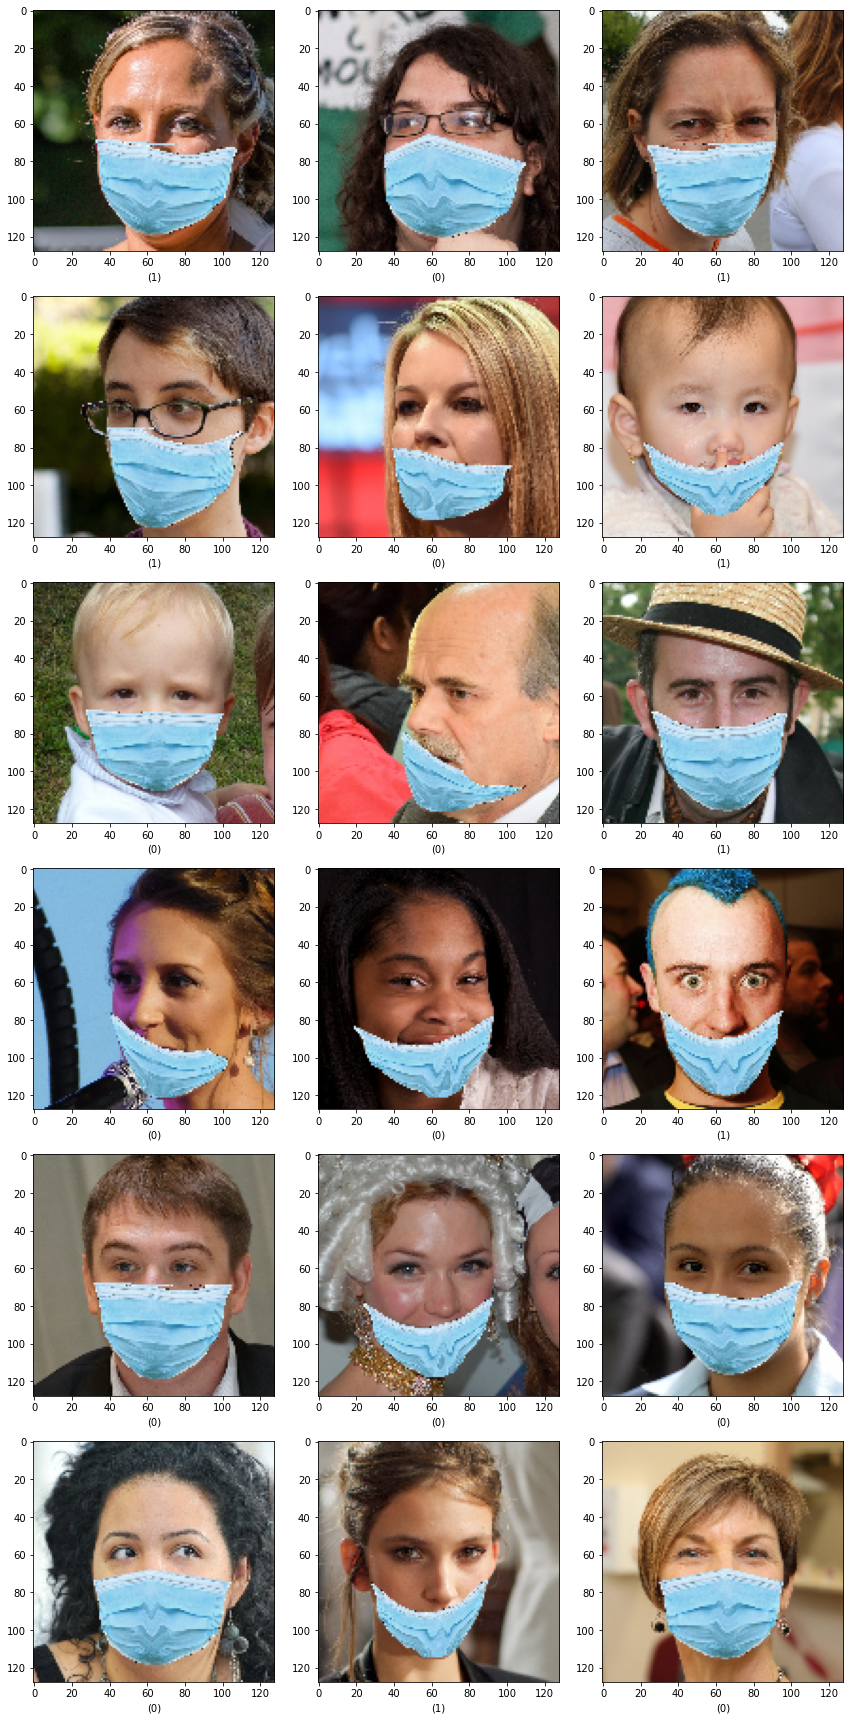

In [45]:
# Predicted result with images
sample_test = validate_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = y_final[index][1]
    img = load_img(sample_test["filename"][index],target_size=(128, 128))
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel( '(' + "{}".format(category) + ')')
plt.tight_layout()
plt.show()